<a href="https://colab.research.google.com/github/jiyoungemma/Uber_fare_prediction/blob/main/Uber_fare_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 라이브러리

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install category_encoders

In [ ]:
pip install xgboost

In [ ]:
pip install eli5

In [ ]:
pip install shap

In [ ]:
pip install pdpbox

In [ ]:
pip uninstall matplotlib

In [ ]:
pip install --upgrade matplotlib

In [5]:
import pandas as pd
import datetime
import geopy.distance
import matplotlib.pyplot as plt
import matplotlib 
matplotlib.font_manager._rebuild()
%matplotlib inline 
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from pandas.util.testing import assert_frame_equal
from sklearn.pipeline import make_pipeline
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from category_encoders import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import randint, uniform
from pdpbox.pdp import pdp_interact, pdp_interact_plot
import shap
from xgboost import plot_importance

### 데이터 불러오기

In [77]:
df = pd.read_csv('/content/drive/MyDrive/uber.csv')
df

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5
...,...,...,...,...,...,...,...,...,...
199995,42598914,2012-10-28 10:49:00.00000053,3.0,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1
199996,16382965,2014-03-14 01:09:00.0000008,7.5,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1
199997,27804658,2009-06-29 00:42:00.00000078,30.9,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2
199998,20259894,2015-05-20 14:56:25.0000004,14.5,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,1


### 전처리

In [78]:
df.rename(columns={'Unnamed: 0' : 'customer'} ,inplace=True)
df['pickup_datetime'] = df['pickup_datetime'].apply(str).apply(lambda x: x[:-3])
df.drop(columns='key',inplace=True)

In [79]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [9]:
df.dtypes

customer                      int64
fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dtype: object

In [80]:
df['year'] = df.pickup_datetime.dt.year
df['month'] = df.pickup_datetime.dt.month
df['weekday'] = df.pickup_datetime.dt.weekday # 0: 월, 1:화, 2:수, 3:목, 4:금, 5:토, 6:일
df['hour'] = df.pickup_datetime.dt.hour

In [11]:
df.head()

,customer,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,weekday,hour
0,24238194,7.5,2015-05-07 19:52:06,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,3,19
1,27835199,7.7,2009-07-17 20:04:56,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,4,20
2,44984355,12.9,2009-08-24 21:45:00,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,0,21
3,25894730,5.3,2009-06-26 08:22:21,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,4,8
4,17610152,16.0,2014-08-28 17:47:00,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,3,17


In [12]:
df.isna().sum()

customer             0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
year                 0
month                0
weekday              0
hour                 0
dtype: int64

In [81]:
df.dropna(inplace=True) # 결측치가 승객이 내린 위치의 경도, 위도에 하나씩만 존재하기 때문에 제거

In [82]:
# 경도 위도에 대한 잘못된 값 제거(경도의 경우 -180 ~ +180, 위도의 경우 -90 ~ +90)
df = df[(df.pickup_latitude<90) & (df.dropoff_latitude<90) &
        (df.pickup_latitude>-90) & (df.dropoff_latitude>-90) &
        (df.pickup_longitude<180) & (df.dropoff_longitude<180) &
        (df.pickup_longitude>-180) & (df.dropoff_longitude>-180)]

In [83]:
# 위도 경도 기준으로 거리 계산
df['distance']=[round(geopy.distance.distance((df.pickup_latitude[i], df.pickup_longitude[i]),(df.dropoff_latitude[i], df.dropoff_longitude[i])).km,2) for i in df.index]

In [17]:
df.head()

,customer,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,weekday,hour,distance
0,24238194,7.5,2015-05-07 19:52:06,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,3,19,1.68
1,27835199,7.7,2009-07-17 20:04:56,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,4,20,2.45
2,44984355,12.9,2009-08-24 21:45:00,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,0,21,5.04
3,25894730,5.3,2009-06-26 08:22:21,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,4,8,1.66
4,17610152,16.0,2014-08-28 17:47:00,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,3,17,4.48


In [18]:
df.describe()

,customer,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,weekday,hour,distance
count,1.999870e+05,199987.000000,199987.000000,199987.000000,199987.000000,199987.000000,199987.000000,199987.000000,199987.000000,199987.000000,199987.000000,199987.000000
mean,2.771284e+07,11.359849,-72.501786,39.917937,-72.511608,39.922031,1.684544,2011.742463,6.281783,3.048383,13.491562,20.563460
std,1.601384e+07,9.901868,10.449955,6.130412,10.412192,6.117669,1.385999,1.856438,3.438957,1.946960,6.515458,379.663759
min,1.000000e+00,-52.000000,-93.824668,-74.015515,-75.458979,-74.015750,0.000000,2009.000000,1.000000,0.000000,0.000000,0.000000
25%,1.382554e+07,6.000000,-73.992064,40.734793,-73.991407,40.733823,1.000000,2010.000000,3.000000,1.000000,9.000000,1.220000
50%,2.774626e+07,8.500000,-73.981822,40.752592,-73.980092,40.753042,1.000000,2012.000000,6.000000,3.000000,14.000000,2.120000
75%,4.155554e+07,12.500000,-73.967154,40.767157,-73.963658,40.768000,2.000000,2013.000000,9.000000,5.000000,19.000000,3.870000
max,5.542357e+07,499.000000,40.808425,48.018760,40.831932,45.031598,208.000000,2015.000000,12.000000,6.000000,23.000000,8783.590000


<image src = "https://i0.wp.com/uponarriving.com/wp-content/uploads/2020/10/Uber-fees.png" width = 500, height= 500>

출처 : https://www.uponarriving.com/uber-charge-per-mile/#Minimum_fare

In [85]:
# 요금이 1불 이하인 경우 제거
fareminus = df.loc[df['fare_amount'] < 1].index
df.drop(fareminus,inplace=True)

# 승객 수가 0명인 경우 제거
zero = df.loc[df['passenger_count'] == 0].index
df.drop(zero,inplace=True)

# 승객 수가 208명인 이상치 제거 --> 208명을 제외하면 데이터의 승객수는 10명 이하 
two = df.loc[df['passenger_count'] == 208].index
df.drop(two,inplace=True)

# 위도나 경도가 하나라도 0이 포함된 경우 제거 -> 위도 경도가 0인 곳은 대서양
# 서울에서 베이징까지의 거리가 956km
# 서울에서 제주도까지 직선거리 455km
zero_long_lati = df.loc[(df['pickup_longitude'] == 0) | (df['pickup_latitude'] == 0) | (df['dropoff_longitude'] == 0) | (df['dropoff_latitude'] == 0)].index
df.drop(zero_long_lati, inplace=True)

# 거리가 1km 미만인 경우 제거
dis_zero = df.loc[df['distance'] < 1].index
df.drop(dis_zero, inplace=True)

# 불필요한 칼럼 제거
df.drop(columns = 'pickup_datetime', inplace=True)

In [86]:
df.shape

(163450, 12)

### 승객수에 대한 시각화

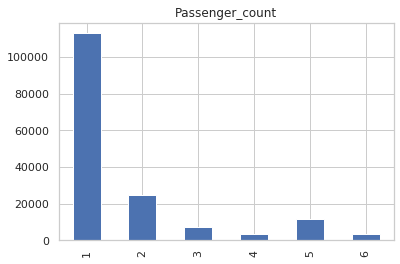

In [103]:
df = df.sort_values(by = 'passenger_count')
passenger = pd.value_counts(df['passenger_count'].values, sort=False)
passenger.plot.bar(color="b");
plt.title("Passenger_count");

- 승객 1명이 가장 많이 나타났고 그 다음으로 2명이 가장 많이 탑승함

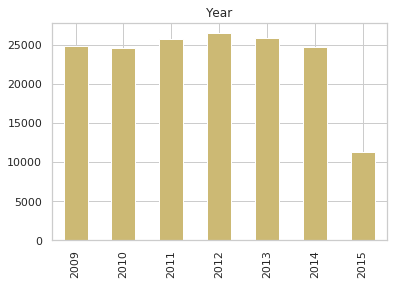

In [102]:
df = df.sort_values(by = 'year')
year = pd.value_counts(df['year'].values, sort=False)
year.plot.bar(color="y");
plt.title("Year");

- 2009년에서 2015년까지의 연도별 승객 수를 나타냄
   - 대체로 승객수가 비슷하게 나타남
   - 2015년의 경우 6월까지의 데이터까지만 존재하기 때문에 낮게 나타난 것으로 예상

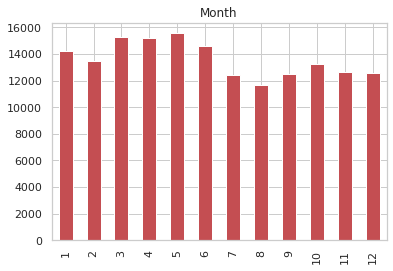

In [101]:
df = df.sort_values(by = 'month')
month = pd.value_counts(df['month'].values, sort=False)
month.plot.bar(color="r");
plt.title("Month");

- 대체로 비슷한 추이를 보이지만 8월이 가장 낮은 모습을 보임

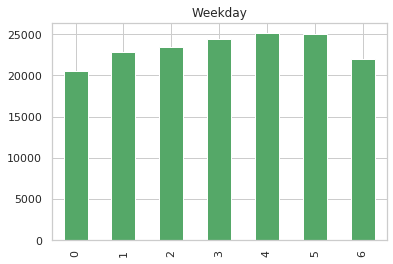

In [100]:
df = df.sort_values(by = 'weekday')
weekday = pd.value_counts(df['weekday'].values, sort=False)
weekday.plot.bar(color="g");
plt.title("Weekday");

- 0: 월, 1:화, 2:수, 3:목, 4:금, 5:토, 6:일
- 월요일이 가장 낮은 추이를 보임
   - 월요일이 주말과 비슷하게 나타날 것으로 생각했음
   - 2015년의 요일 편향이 존재했는지 -> 아님

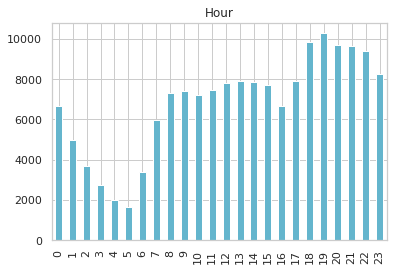

In [99]:
df = df.sort_values(by = 'hour')
hour = pd.value_counts(df['hour'].values, sort=False)
hour.plot.bar(color="c");
plt.title("Hour");

- 2, 3, 4, 5시 시간대의 승객수가 가장 낮은 모습을 보였음
   - 새벽시간대이기 때문에 대부분의 사람들이 잠을 자는 시간대이기때문일 것이라 예상
   - 퇴근시간대인 18시부터 21시에 승객수가 가장 많은 모습

### 타겟값 파악

In [104]:
df['fare_amount'].describe()

count    163450.000000
mean         12.390480
std           9.827713
min           2.500000
25%           6.900000
50%           9.300000
75%          13.700000
max         230.000000
Name: fare_amount, dtype: float64

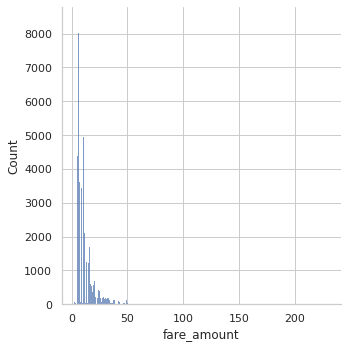

In [105]:
target = df['fare_amount']
sns.displot(target);

### 모델링

In [106]:
train, test = train_test_split(df, train_size=0.8, test_size=0.2, random_state=2)

train.shape, test.shape

((130760, 12), (32690, 12))

In [107]:
train, val = train_test_split(train, train_size=0.8, test_size=0.2, random_state=2)

train.shape, val.shape, test.shape

((104608, 12), (26152, 12), (32690, 12))

In [25]:
df.columns

Index(['customer', 'fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'weekday', 'hour', 'distance'],
      dtype='object')

In [108]:
target = 'fare_amount'

X_train = train.drop('fare_amount', axis=1)
y_train = train[target]
X_val = val.drop('fare_amount', axis=1)
y_val = val[target]
X_test = test.drop('fare_amount', axis=1)
y_test = test[target]

### Baseline model
- 선형회귀 모델
   - 타겟값이 우버요금인 회귀문제
   - 회귀모델 중 가장 기본적인 모델인 다중선형회귀 모델을 기준모델로 설정
- 평균값이 아닌 선형회귀를 기준모델로 선정한 이유
   - 학습 속도와 예측이 빠름
   - 매우 큰 데이터와 희소 데이터에도 잘 작동
   - 다만 선형관계임을 가정하고 있어 꼭 예측이 정확하다고 할 수는 없음
   - 또한, 특이값에 민감한 모델
   - 이런 단점이 더 크게 작동하여 현 데이터셋의 선형회귀를 사용했을 때 값이 다소 낮게 나오는 것으로 보임

In [109]:
# 선형회귀 기준모델
model = LinearRegression()

model.fit(X_train, y_train)
y_pred = model.predict(X_val)

In [110]:
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_val, y_pred)

display(pd.DataFrame([['MSE', mse],['MAE', mae],['RMSE', rmse],['R2', r2]], columns=['Metric', 'Score']))

,Metric,Score
0,MSE,96.731620
1,MAE,6.137732
2,RMSE,9.835223
3,R2,0.021243


In [111]:
# 칼럼간의 상관관계 확인
df.corr()

,customer,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,weekday,hour,distance
customer,1.000000,-0.001382,0.000687,-0.001420,0.001343,-0.001286,0.003102,-0.001475,0.000076,-0.003485,-0.000356,0.001138
fare_amount,-0.001382,1.000000,0.015839,-0.012858,0.013800,-0.012853,0.012670,0.136736,0.023626,0.001027,-0.022976,0.033990
pickup_longitude,0.000687,0.015839,1.000000,-0.960117,0.931139,-0.954392,0.011019,0.013653,-0.008210,0.007780,-0.000228,0.175684
pickup_latitude,-0.001420,-0.012858,-0.960117,1.000000,-0.961834,0.990263,-0.010608,-0.013971,0.007896,-0.008394,0.000129,-0.025312
dropoff_longitude,0.001343,0.013800,0.931139,-0.961834,1.000000,-0.962418,0.010894,0.012801,-0.007106,0.007860,-0.001107,0.158183
dropoff_latitude,-0.001286,-0.012853,-0.954392,0.990263,-0.962418,1.000000,-0.011620,-0.013491,0.007408,-0.008464,0.000105,-0.043610
passenger_count,0.003102,0.012670,0.011019,-0.010608,0.010894,-0.011620,1.000000,0.006695,0.008414,0.035322,0.014674,0.004971
year,-0.001475,0.136736,0.013653,-0.013971,0.012801,-0.013491,0.006695,1.000000,-0.113304,0.006207,0.002343,-0.000479
month,0.000076,0.023626,-0.008210,0.007896,-0.007106,0.007408,0.008414,-0.113304,1.000000,-0.010433,-0.003552,-0.001357
weekday,-0.003485,0.001027,0.007780,-0.008394,0.007860,-0.008464,0.035322,0.006207,-0.010433,1.000000,-0.090681,0.001771


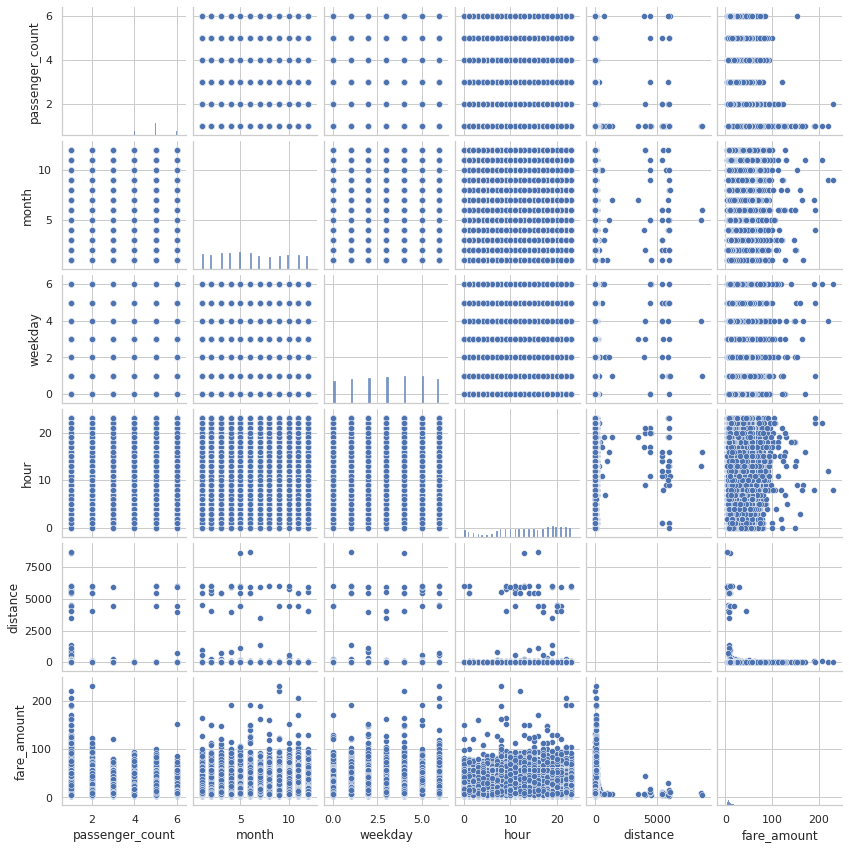

In [112]:
sns.set(style='whitegrid', context='notebook')
cols = ['passenger_count', 'month','weekday', 'hour', 'distance', 'fare_amount']
sns.pairplot(df[cols], height=2);

- 데이터가 선형성을 띄고 있지 않아 선형회귀 모델을 사용했을 때 성능이 매우 낮게 나타난 것으로 판단

### XGB 회귀 모델
- XGB 회귀 모델은 예측력이 좋아 빠르게 적합학 파라미터를 찾기 때문에 사용

In [113]:
boosting = XGBRegressor(
    n_estimators=10000,
    objective='reg:squarederror', 
    learning_rate=0.2,
    n_jobs=-1
)

eval_set = [(X_train, y_train), 
            (X_val, y_val)]

In [114]:
boosting.fit(X_train, y_train, 
          eval_set=eval_set,
          early_stopping_rounds=50
         )

[0]	validation_0-rmse:12.6131	validation_1-rmse:12.7164
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:10.4279	validation_1-rmse:10.5237
[2]	validation_0-rmse:8.73815	validation_1-rmse:8.83318
[3]	validation_0-rmse:7.43108	validation_1-rmse:7.52283
[4]	validation_0-rmse:6.4397	validation_1-rmse:6.5355
[5]	validation_0-rmse:5.69926	validation_1-rmse:5.79535
[6]	validation_0-rmse:5.15498	validation_1-rmse:5.25005
[7]	validation_0-rmse:4.75818	validation_1-rmse:4.85886
[8]	validation_0-rmse:4.47068	validation_1-rmse:4.55851
[9]	validation_0-rmse:4.27041	validation_1-rmse:4.35761
[10]	validation_0-rmse:4.11431	validation_1-rmse:4.2043
[11]	validation_0-rmse:3.98441	validation_1-rmse:4.09049
[12]	validation_0-rmse:3.89903	validation_1-rmse:3.99704
[13]	validation_0-rmse:3.82891	validation_1-rmse:3.929
[14]	validation_0-rmse:3.77903	validation_1-rmse:3.88591
[

XGBRegressor(learning_rate=0.2, n_estimators=10000, n_jobs=-1,
             objective='reg:squarederror')

In [115]:
boosting.score(X_val, y_val)

0.893798871705251

In [116]:
y_pred_boost = boosting.predict(X_val)
mse = mean_squared_error(y_val, y_pred_boost)
mae = mean_absolute_error(y_val, y_pred_boost)
rmse = mse ** 0.5
r2 = r2_score(y_val, y_pred_boost)

display(pd.DataFrame([['MSE', mse],['MAE', mae],['RMSE', rmse],['R2', r2]], columns=['Metric', 'Score']))

,Metric,Score
0,MSE,10.495972
1,MAE,1.730201
2,RMSE,3.239749
3,R2,0.893799


- 기준모델과 비교했을 때 성능이 높아진 것을 확인
- 편향되어 있는 타겟값을 정규화형태로 변환하고 모델링을 진행했었는데 정규화형태로 변환한 모델링보다 기존 타겟값을 사용했을 때 더 나은 성능을 보임
   - 요금을 예측하는 모델이기 때문에 편향된 값에 크게 영향을 받지 않는 것으로 보임

### RandomForest 회귀 모델
- RandomForest는 분류, 회귀 모두 사용가능하고 대용량데이터 처리가 쉽다는 것, 과적합문제를 해결해주고 특성중요도를 구할 수 있음
- RandomizedSearchCV 를 통해 최적의 하이퍼파라미터 찾기
   - GridSearchCV 와 달리 범위를 정하여 찾을 수 있어 사용

In [117]:
pipe = make_pipeline(
    RandomForestRegressor(random_state=2)
)

param_distributions = { 
    'randomforestregressor__n_estimators': randint(500, 1000), 
    'randomforestregressor__max_depth': randint(10, 30), 
    'randomforestregressor__max_features': uniform(0, 1)
}

search = RandomizedSearchCV(
    pipe, 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=3, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=2,
    error_score = 'raise'
)

search.fit(X_train, y_train);
print('최적 하이퍼파라미터: ', search.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
최적 하이퍼파라미터:  {'randomforestregressor__max_depth': 21, 'randomforestregressor__max_features': 0.4353223926182769, 'randomforestregressor__n_estimators': 860}


In [118]:
pipe = make_pipeline(
    RandomForestRegressor(n_estimators=860, max_depth=21, random_state=2, max_features=0.4353223926182769)
)

tt = TransformedTargetRegressor(regressor=pipe,
                                func=np.log1p, inverse_func=np.expm1)

tt.fit(X_train, y_train)
tt.score(X_val, y_val)

0.8804187992503676

In [119]:
y_pred_random = tt.predict(X_val)

mse = mean_squared_error(y_val, y_pred_random)
mae = mean_absolute_error(y_val, y_pred_random)
rmse = mse ** 0.5
r2 = r2_score(y_val, y_pred_random)

display(pd.DataFrame([['MSE', mse],['MAE', mae],['RMSE', rmse],['R2', r2]], columns=['Metric', 'Score']))

,Metric,Score
0,MSE,11.818339
1,MAE,1.741559
2,RMSE,3.437781
3,R2,0.880419


In [ ]:
# mse, mae, rmse : 비용함수 = 낮을수록 좋음
# r2 = 높을수록 좋음

- xgbregressor 모델이 더 좋음

In [120]:
y_pred = boosting.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

display(pd.DataFrame([['MSE', mse],['MAE', mae],['RMSE', rmse],['R2', r2]], columns=['Metric', 'Score']))

,Metric,Score
0,MSE,10.718244
1,MAE,1.737122
2,RMSE,3.273873
3,R2,0.888630


### PDP 를 통해 특성들의 관계 파악

In [70]:
df.columns

Index(['customer', 'fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'weekday', 'hour', 'distance'],
      dtype='object')

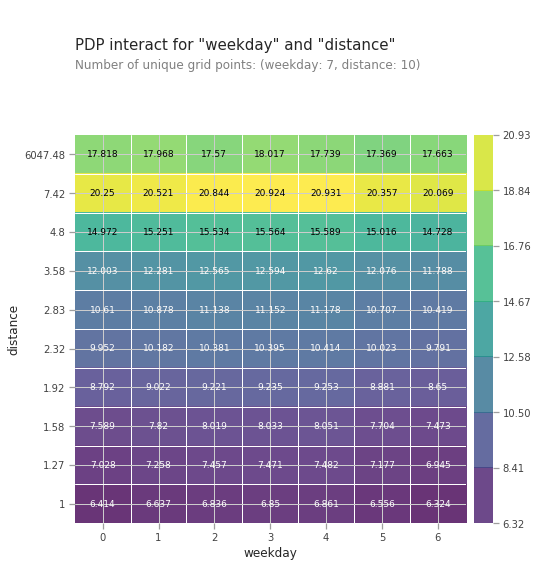

In [121]:
features = ['weekday','distance']

interaction = pdp_interact(
    model=boosting, 
    dataset=X_val,
    model_features=X_val.columns, 
    features=features
)
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

- 요일별 이동 거리가 비슷한 모습을 보임

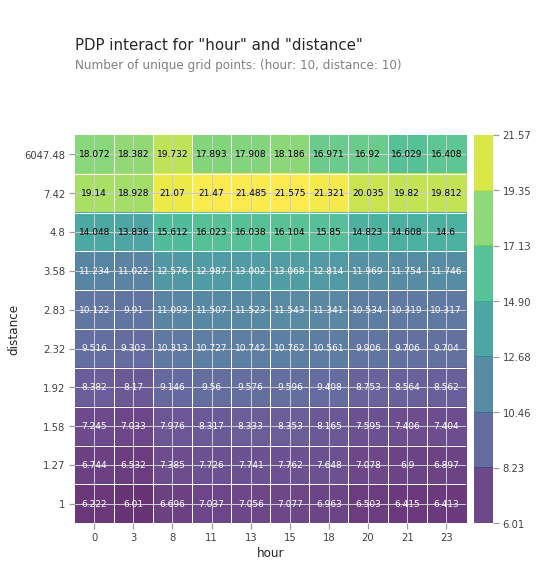

In [122]:
features = ['hour','distance']

interaction = pdp_interact(
    model=boosting, 
    dataset=X_val,
    model_features=X_val.columns, 
    features=features
)
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

- 15시에서 18시 사이가 가장 상관관계가 높게 나타남

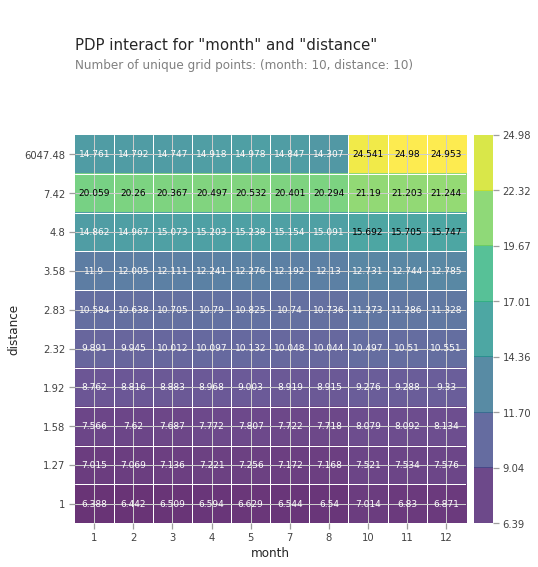

In [123]:
features = ['month','distance']

interaction = pdp_interact(
    model=boosting, 
    dataset=X_val,
    model_features=X_val.columns, 
    features=features
)
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

### Shap 시각화
- 특성이 타겟에 미치는 영향을 알아보기 위함

In [124]:
explainer = shap.TreeExplainer(boosting)
shap_values = explainer.shap_values(X_test)

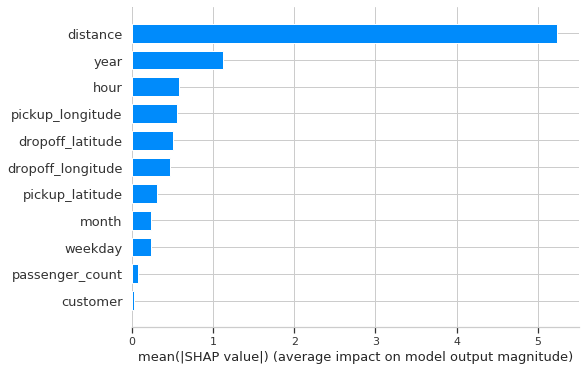

In [127]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

- 거리가 가장 많은 영향을 미치는 것으로 나타남